# Geolocalizador

Autora: Sofía Barreto Ojeda

El objetivo de este proyecto es hacer una visualizacion de los eventos bélicos en territorio ucraniano y atribuidos al hostigamiento ruso. Este notebook incluye tres secciones:

**1. Descarga de Datos.**

**2. Analisis Exploratorio de Datos.**

**3. Visualización de Datos.**

**4. Siguientes pasos.**

Vamos a usar las librerias: 
- `urllib` para extraer la informacion, 
- `pandas`, para tabular la informacion encontrada.
- `geoplotlib` y `plotly`, para generar el mapa de Ucrania y visualizar la golocalizacion de los bombardeos.

-----

Antes de iniciar, importamos las librerías que vamos a usar en este notebook:

In [1]:
# descargar datos
from urllib.request import urlopen

#json
import json

# tabular
import pandas as pd

# maps
import plotly.express as px

----

## 1. Descarga de Datos

Los detalles de los eventos se obtienen de la base de datos proviene del grupo de periodismo investigativo [Bellingcat](https://en.wikipedia.org/wiki/Bellingcat). Esta base de datos que muestra fecha, hora, ubicación, y coordenadas de cada evento.

La base de datos esta disponible en el siguiente link, al que llamamos `url`:

In [2]:
url = 'https://ukraine.bellingcat.com/ukraine-server/api/ukraine/export_events/deeprows'

El siguiente paso es guardar la informacion de nuestro url en la variable `data`. Dado que los datos están almacenados en formato json, podemos usar la función `json.load` para almacenar nuestros datos en la variable `datos`.

In [3]:
json.load?

Signature:
json.load(
    fp,
    *,
    cls=None,
    object_hook=None,
    parse_float=None,
    parse_int=None,
    parse_constant=None,
    object_pairs_hook=None,
    **kw,
)
Docstring:
Deserialize ``fp`` (a ``.read()``-supporting file-like object containing
a JSON document) to a Python object.

``object_hook`` is an optional function that will be called with the
result of any object literal decode (a ``dict``). The return value of
``object_hook`` will be used instead of the ``dict``. This feature
can be used to implement custom decoders (e.g. JSON-RPC class hinting).

``object_pairs_hook`` is an optional function that will be called with the
result of any object literal decoded with an ordered list of pairs.  The
return value of ``object_pairs_hook`` will be used instead of the ``dict``.
This feature can be used to implement custom decoders.  If ``object_hook``
is also defined, the ``object_pairs_hook`` takes priority.

To use a custom ``JSONDecoder`` subclass, specify it with th

Así, almacenamos la información en `datos`:

In [4]:
with urlopen(url) as response:
    datos = json.load(response)

Podemos revisar el numero de eventos registrados con `len`, de donde se puede ver que hay 432 entradas.

In [5]:
len(datos)

432

Ya que tenemos la información almacedanada en la variable `datos`, podemos proceder a hacer un breve análisis exploratorio de datos.

## 2. Análisis Exploratorio de Datos

Como primer paso, podemos revisar el tipo de información obtenida de la base de datos. Dado que la información está contenida en un archivo de formato json, podemos extraer las llaves del primer elemento de la variable `datos` para saber el tipo de datos con los que contamos:

In [6]:
columns = (datos[0].keys()) # muestra las llaves de la primera entrada de la variable datos
print(f"{len(columns)} columnas.\n{columns}")

9 columnas.
dict_keys(['associations', 'sources', 'id', 'description', 'date', 'time', 'location', 'latitude', 'longitude'])


De aqui podemos ver que tenemos 9 diferentes columnas:
- `associations` 
- `sources` 
- `id` 
- `description` 
- `date` 
- `time`
- `location` 
- `latitude`
- `longitude`

Ahora que tenemos una mejor idea del tipo de información almacenada en `datos`, podemos usas la libreria [pandas](https://pandas.pydata.org/docs/index.html) para usar `DataFrames` en lugar de formato json.

### 2.1 Json a DataFrame

Para convertir la información de json a DataFrames, podemos usar la función `json_normalize` disponible en la libreria pandas. Por ejemplo, para la primera entrada podemos convertir json a `DataFrame` con:

In [7]:
df1 = pd.json_normalize(datos[0]) # convierte json a dataframe, primera entrada
df1

,associations,sources,id,description,date,time,location,latitude,longitude
0,"[asc1, asc11]","[src_exists_CIV0001_1, src_exists_CIV0001_2, s...",CIV0001,"Apartment block hit. Crater is very large, pos...",02/24/2022,00:00,"Chuhuiv, south of Kharkiv",49.85005,36.659031


Aquí llamamos `df1` a la variable que almacena una DataFrame para la primera entrada.

### 2.2. Suprimir información no necesaria

Adicionalmente, dado que nuestro objetivo es visualizar eventos (geolocalizador), de la información obtenida podemos suprimir las columnas `associations`, `sources`, `id`, y `time`. Para borras estas filas, podemos usar `.drop()`:

In [8]:
df = df1.drop(columns=['associations', 'sources', 'id', 'time'])

Antes de continuar, también debemos verificar que los valores de la columna `latitude` and `longitude` son de typo `float`. 

In [9]:
cols_ = ['latitude', 'longitude']

Como se puede verificar en la siguiente celda, las columnas `latitude` and `longitude` son de typo `str`.

In [10]:
[type(df[i][0]) for i in cols_]

[str, str]

### 2.3. Convertir tipos de variables

Para convertirlas a float hacemos:

In [11]:
df.astype({'latitude': 'float', 'longitude':'float'}).dtypes

description     object
date            object
location        object
latitude       float64
longitude      float64
dtype: object

De aquí también podemos ver que la columna `date` requiere de formato de fecha. Para asignar el formato apropiado hacemos:

In [12]:
df['date'] = pd.to_datetime(df['date'])

De forma que tenemos una DataFrame con 5 columnas:

In [13]:
df

,description,date,location,latitude,longitude
0,"Apartment block hit. Crater is very large, pos...",2022-02-24,"Chuhuiv, south of Kharkiv",49.85005,36.659031


donde podemos ver que la fecha contenida en la columna `date` ahora tiene formato de `año-mes-día`.

De la DataFrame obtenida, podemos identificar información clave para construir nuestro geolocalizador. Las dos columnas de datos más importantes son las de `latitude` and `longitud`, las cuales proveen información geográfica para graficar en el mapa.

## 3. Visualización de Datos

Para visualizar los datos de latitud y longitud podemos hacer uso de la librería [plotly express](https://plotly.com/python/plotly-express/).

Especificamente, con [scatter_mapbox](https://plotly.com/python/scattermapbox/) podemos crear un gráfico de dispersión superpuesto sobre el mapa de Ucrania. Cada fila de una data frame es representada por un punto o símbolo (marcador).

Por ejemplo, para visualizar el primer evento de agresión registrado como parte de la estrategia Rusa en el conflicto con Ucrania, podemos usar `px.scatter_mapbox`.

```Python
px.scatter_mapbox(lon =,          # datos de longitud
                  lat =,          # datos de latitud
                  mapbox_style =, # estilo del mapbox
                  zoom =,         # zoom
                  size =          # tamaño del marcador
                 )
```

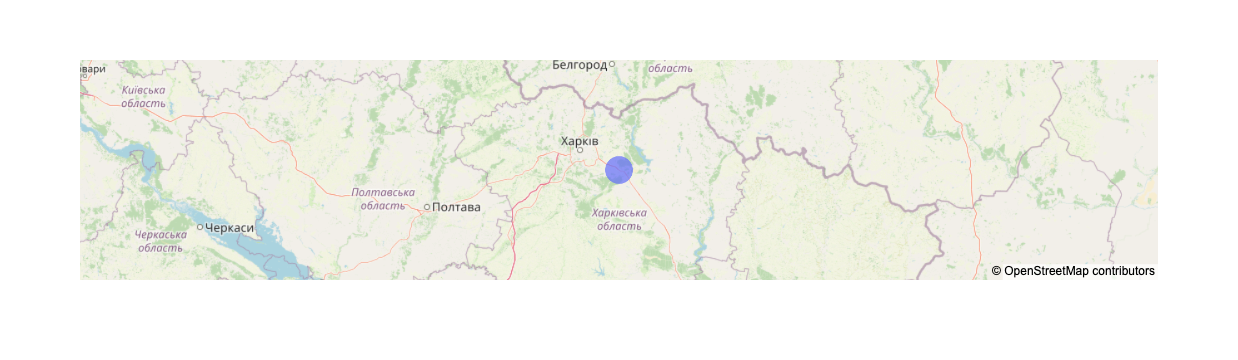

In [20]:
px.scatter_mapbox(lon=df['longitude'], lat=df['latitude'], mapbox_style='open-street-map', zoom=6, size=df.index+100)

De esta forma podemos visualizar de forma interactiva la información disponible en nuestra base da datos.

---

## Siguientes pasos

Ahora que tenemos clara la estructura de datos con la cual vamos a trabajar, podemos proceder a limpiar la base de datos inicial para las 432 entradas encontradas. Para ello podemos usar un for loop con el que evaluamos todas las entradas contenidas en el archivo json. 

Despues podemos aplicar los pasos 2.1 a 2.3 para usar DataFrames en lugar de json; para suprimir información no necesaria; y para asignar tipos de variable apropiados.

Estos pasos se realizarán en el siguiente notebook.

---